In [ ]:
#PART1: DATA COLLECTION

In [ ]:
#Code for scraping 100 movies in 2025

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd
import time
import random

In [ ]:

def seemore(driver):
    """Clicks the 'See More' button multiple times if available."""
    # Try to close any pop-up or cookie consent banner
    try:
        close_btn = driver.find_element(By.XPATH, '//button[contains(text(), "Accept")]')
        close_btn.click()
    except:
        pass

    # Give time for page to load
    driver.implicitly_wait(5)

    # Click 'See More' button up to 2 times
    for _ in range(2):
        try:
            show_more_btn = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'ipc-see-more__button')]"))
            )
            driver.execute_script("arguments[0].click();", show_more_btn)

            # Wait until button is no longer active
            WebDriverWait(driver, 10).until(
                EC.invisibility_of_element_located(
                    (By.XPATH, "//button[contains(@class, 'ipc-see-more__button') and @disabled]")
                )
            )
            time.sleep(1)  # Short pause between clicks
        except:
            break  # Stop if button not found or not clickable

    # Scroll to load any lazy-loaded content
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.implicitly_wait(5)
    return driver

def get_movie_list(url):
    """Get the initial list of movies from IMDb search page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        driver.get(url)
        driver = seemore(driver)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        
        # Extract basic movie data
        mdata = []
        for mov in soup.find_all('div', class_='dli-parent'):
            name_elem = mov.find('h3', class_='ipc-title__text')
            if name_elem:
                name = name_elem.text
                # Clean up the name (remove numbering if present)
                if "." in name and name[0].isdigit():
                    name = name.split(".", 1)[1].strip()
                    
                # Get the movie URL for box office data
                link_elem = mov.find('a', class_='ipc-title-link-wrapper')
                movie_url = f"https://www.imdb.com{link_elem['href'].split('?')[0]}" if link_elem else None
                
                mdata.append({
                    'Movie': name,
                    'Rating': mov.find('span', class_='ipc-rating-star--rating').text if mov.find('span', class_='ipc-rating-star--rating') else "",
                    'Votes': mov.find('span', class_='ipc-rating-star--voteCount').text if mov.find('span', class_='ipc-rating-star--voteCount') else "",
                    'Plot': mov.find('div', class_='ipc-html-content-inner-div').text if mov.find('div', class_='ipc-html-content-inner-div') else "",
                    'URL': movie_url
                })
        
        return mdata
    except Exception as e:
        print(f"Error fetching movie list: {e}")
        return []
    finally:
        driver.quit()  # Always close this driver

def get_box_office_data(movie_data):
    """Add box office data to the movie list by visiting each movie page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        for i, movie in enumerate(movie_data):
            if movie['URL']:
                print(f"Getting box office data for {i+1}/{len(movie_data)}: {movie['Movie']}")
                
                try:
                    driver.get(movie['URL'])
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.TAG_NAME, "body"))
                    )
                    
                    # Initialize box office values
                    movie['Budget'] = "N/A"
                    movie['Opening Weekend US/Canada'] = "N/A"
                    movie['Gross US/Canada'] = "N/A"
                    movie['Gross Worldwide'] = "N/A"
                    
                    # Look for box office section
                    try:
                        WebDriverWait(driver, 5).until(
                            EC.presence_of_element_located((By.XPATH, "//section[contains(@data-testid, 'BoxOffice')]"))
                        )
                        
                        soup = BeautifulSoup(driver.page_source, 'lxml')
                        box_office_section = soup.find('section', {'data-testid': 'BoxOffice'})
                        
                        if box_office_section:
                            # Find all box office data items
                            items = box_office_section.find_all('li', {'class': 'ipc-metadata-list__item'})
                            
                            for item in items:
                                label = item.find('span', {'class': 'ipc-metadata-list-item__label'})
                                if not label:
                                    continue
                                
                                label_text = label.text.strip()
                                value = item.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                                value_text = value.text.strip() if value else "N/A"
                                
                                # Map each label to the appropriate field
                                if 'Budget' in label_text:
                                    movie['Budget'] = value_text
                                elif 'Opening' in label_text and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text):
                                    movie['Opening Weekend US/Canada'] = value_text
                                elif ('Gross' in label_text or 'gross' in label_text) and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text) and 'Worldwide' not in label_text:
                                    movie['Gross US/Canada'] = value_text
                                elif 'Worldwide' in label_text or ('Gross' in label_text and 'worldwide' in label_text.lower()):
                                    movie['Gross Worldwide'] = value_text
                        else:
                            print(f"No box office section found for {movie['Movie']}")
                            
                    except TimeoutException:
                        print(f"Box office section not found for {movie['Movie']}")
                    except Exception as e:
                        print(f"Error extracting box office data for {movie['Movie']}: {e}")
                        
                except Exception as e:
                    print(f"Error processing {movie['Movie']}: {e}")
                    
                # Add a random delay between requests to avoid being blocked
                time.sleep(random.uniform(1, 3))
            else:
                print(f"No URL available for {movie['Movie']}")
                
        return movie_data
    except Exception as e:
        print(f"General error in box office collection: {e}")
        return movie_data
    finally:
        driver.quit()  # Always close this driver

def main():
    url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2025-01-01,2025-03-31&sort=num_votes,desc"
    
    print("Step 1: Getting movie list...")
    movie_data = get_movie_list(url)
    
    if movie_data:
        print(f"Found {len(movie_data)} movies")
        
        print("\nStep 2: Adding box office data...")
        movie_data = get_box_office_data(movie_data)
        
        # Create and save DataFrame
        df = pd.DataFrame(movie_data)
        output_file = 'imdb_scraped_data_with_box_office.xlsx'
        df.to_excel(output_file, index=False)
        print(f"\nData saved to {output_file}")
        print(df.head())
    else:
        print("No movies found. Check if IMDb has changed their page structure.")

if __name__ == "__main__":
    main()

Step 1: Getting movie list...


In [ ]:
#Code scraping 100 movies 2024

In [ ]:


def seemore(driver):
    """Clicks the 'See More' button multiple times if available."""
    # Try to close any pop-up or cookie consent banner
    try:
        close_btn = driver.find_element(By.XPATH, '//button[contains(text(), "Accept")]')
        close_btn.click()
    except:
        pass

    # Give time for page to load
    driver.implicitly_wait(5)

    # Click 'See More' button up to  times
    for _ in range(1):
        try:
            show_more_btn = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'ipc-see-more__button')]"))
            )
            driver.execute_script("arguments[0].click();", show_more_btn)

            # Wait until button is no longer active
            WebDriverWait(driver, 10).until(
                EC.invisibility_of_element_located(
                    (By.XPATH, "//button[contains(@class, 'ipc-see-more__button') and @disabled]")
                )
            )
            time.sleep(1)  # Short pause between clicks
        except:
            break  # Stop if button not found or not clickable

    # Scroll to load any lazy-loaded content
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.implicitly_wait(5)
    return driver

def get_movie_list(url):
    """Get the initial list of movies from IMDb search page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        driver.get(url)
        driver = seemore(driver)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        
        # Extract basic movie data
        mdata = []
        for mov in soup.find_all('div', class_='dli-parent'):
            name_elem = mov.find('h3', class_='ipc-title__text')
            if name_elem:
                name = name_elem.text
                # Clean up the name (remove numbering if present)
                if "." in name and name[0].isdigit():
                    name = name.split(".", 1)[1].strip()
                    
                # Get the movie URL for box office data
                link_elem = mov.find('a', class_='ipc-title-link-wrapper')
                movie_url = f"https://www.imdb.com{link_elem['href'].split('?')[0]}" if link_elem else None
                
                mdata.append({
                    'Movie': name,
                    'Rating': mov.find('span', class_='ipc-rating-star--rating').text if mov.find('span', class_='ipc-rating-star--rating') else "",
                    'Votes': mov.find('span', class_='ipc-rating-star--voteCount').text if mov.find('span', class_='ipc-rating-star--voteCount') else "",
                    'Plot': mov.find('div', class_='ipc-html-content-inner-div').text if mov.find('div', class_='ipc-html-content-inner-div') else "",
                    'URL': movie_url
                })
        
        return mdata
    except Exception as e:
        print(f"Error fetching movie list: {e}")
        return []
    finally:
        driver.quit()  # Always close this driver

def get_box_office_data(movie_data):
    """Add box office data to the movie list by visiting each movie page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        for i, movie in enumerate(movie_data):
            if movie['URL']:
                print(f"Getting box office data for {i+1}/{len(movie_data)}: {movie['Movie']}")
                
                try:
                    driver.get(movie['URL'])
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.TAG_NAME, "body"))
                    )
                    
                    # Initialize box office values
                    movie['Budget'] = "N/A"
                    movie['Opening Weekend US/Canada'] = "N/A"
                    movie['Gross US/Canada'] = "N/A"
                    movie['Gross Worldwide'] = "N/A"
                    
                    # Look for box office section
                    try:
                        WebDriverWait(driver, 5).until(
                            EC.presence_of_element_located((By.XPATH, "//section[contains(@data-testid, 'BoxOffice')]"))
                        )
                        
                        soup = BeautifulSoup(driver.page_source, 'lxml')
                        box_office_section = soup.find('section', {'data-testid': 'BoxOffice'})
                        
                        if box_office_section:
                            # Find all box office data items
                            items = box_office_section.find_all('li', {'class': 'ipc-metadata-list__item'})
                            
                            for item in items:
                                label = item.find('span', {'class': 'ipc-metadata-list-item__label'})
                                if not label:
                                    continue
                                
                                label_text = label.text.strip()
                                value = item.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                                value_text = value.text.strip() if value else "N/A"
                                
                                # Map each label to the appropriate field
                                if 'Budget' in label_text:
                                    movie['Budget'] = value_text
                                elif 'Opening' in label_text and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text):
                                    movie['Opening Weekend US/Canada'] = value_text
                                elif ('Gross' in label_text or 'gross' in label_text) and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text) and 'Worldwide' not in label_text:
                                    movie['Gross US/Canada'] = value_text
                                elif 'Worldwide' in label_text or ('Gross' in label_text and 'worldwide' in label_text.lower()):
                                    movie['Gross Worldwide'] = value_text
                        else:
                            print(f"No box office section found for {movie['Movie']}")
                            
                    except TimeoutException:
                        print(f"Box office section not found for {movie['Movie']}")
                    except Exception as e:
                        print(f"Error extracting box office data for {movie['Movie']}: {e}")
                        
                except Exception as e:
                    print(f"Error processing {movie['Movie']}: {e}")
                    
                # Add a random delay between requests to avoid being blocked
                time.sleep(random.uniform(1, 3))
            else:
                print(f"No URL available for {movie['Movie']}")
                
        return movie_data
    except Exception as e:
        print(f"General error in box office collection: {e}")
        return movie_data
    finally:
        driver.quit()  # Always close this driver

def main():
    url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2024-01-01,2025-01-01&sort=num_votes,desc"
    
    print("Step 1: Getting movie list...")
    movie_data = get_movie_list(url)
    
    if movie_data:
        print(f"Found {len(movie_data)} movies")
        
        print("\nStep 2: Adding box office data...")
        movie_data = get_box_office_data(movie_data)
        
        # Create and save DataFrame
        df = pd.DataFrame(movie_data)
        output_file = 'imdb_scraped_data_with_box_office1.xlsx'
        df.to_excel(output_file, index=False)
        print(f"\nData saved to {output_file}")
        print(df.head())
    else:
        print("No movies found. Check if IMDb has changed their page structure.")

if __name__ == "__main__":
    main()

In [ ]:
# Code scraping 100 movies 2023
def seemore(driver):
    """Clicks the 'See More' button multiple times if available."""
    # Try to close any pop-up or cookie consent banner
    try:
        close_btn = driver.find_element(By.XPATH, '//button[contains(text(), "Accept")]')
        close_btn.click()
    except:
        pass

    # Give time for page to load
    driver.implicitly_wait(5)

    # Click 'See More' button up to  times
    for _ in range(1):
        try:
            show_more_btn = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'ipc-see-more__button')]"))
            )
            driver.execute_script("arguments[0].click();", show_more_btn)

            # Wait until button is no longer active
            WebDriverWait(driver, 10).until(
                EC.invisibility_of_element_located(
                    (By.XPATH, "//button[contains(@class, 'ipc-see-more__button') and @disabled]")
                )
            )
            time.sleep(1)  # Short pause between clicks
        except:
            break  # Stop if button not found or not clickable

    # Scroll to load any lazy-loaded content
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.implicitly_wait(5)
    return driver

def get_movie_list(url):
    """Get the initial list of movies from IMDb search page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        driver.get(url)
        driver = seemore(driver)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        
        # Extract basic movie data
        mdata = []
        for mov in soup.find_all('div', class_='dli-parent'):
            name_elem = mov.find('h3', class_='ipc-title__text')
            if name_elem:
                name = name_elem.text
                # Clean up the name (remove numbering if present)
                if "." in name and name[0].isdigit():
                    name = name.split(".", 1)[1].strip()
                    
                # Get the movie URL for box office data
                link_elem = mov.find('a', class_='ipc-title-link-wrapper')
                movie_url = f"https://www.imdb.com{link_elem['href'].split('?')[0]}" if link_elem else None
                
                mdata.append({
                    'Movie': name,
                    'Rating': mov.find('span', class_='ipc-rating-star--rating').text if mov.find('span', class_='ipc-rating-star--rating') else "",
                    'Votes': mov.find('span', class_='ipc-rating-star--voteCount').text if mov.find('span', class_='ipc-rating-star--voteCount') else "",
                    'Plot': mov.find('div', class_='ipc-html-content-inner-div').text if mov.find('div', class_='ipc-html-content-inner-div') else "",
                    'URL': movie_url
                })
        
        return mdata
    except Exception as e:
        print(f"Error fetching movie list: {e}")
        return []
    finally:
        driver.quit()  # Always close this driver

def get_box_office_data(movie_data):
    """Add box office data to the movie list by visiting each movie page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        for i, movie in enumerate(movie_data):
            if movie['URL']:
                print(f"Getting box office data for {i+1}/{len(movie_data)}: {movie['Movie']}")
                
                try:
                    driver.get(movie['URL'])
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.TAG_NAME, "body"))
                    )
                    
                    # Initialize box office values
                    movie['Budget'] = "N/A"
                    movie['Opening Weekend US/Canada'] = "N/A"
                    movie['Gross US/Canada'] = "N/A"
                    movie['Gross Worldwide'] = "N/A"
                    
                    # Look for box office section
                    try:
                        WebDriverWait(driver, 5).until(
                            EC.presence_of_element_located((By.XPATH, "//section[contains(@data-testid, 'BoxOffice')]"))
                        )
                        
                        soup = BeautifulSoup(driver.page_source, 'lxml')
                        box_office_section = soup.find('section', {'data-testid': 'BoxOffice'})
                        
                        if box_office_section:
                            # Find all box office data items
                            items = box_office_section.find_all('li', {'class': 'ipc-metadata-list__item'})
                            
                            for item in items:
                                label = item.find('span', {'class': 'ipc-metadata-list-item__label'})
                                if not label:
                                    continue
                                
                                label_text = label.text.strip()
                                value = item.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                                value_text = value.text.strip() if value else "N/A"
                                
                                # Map each label to the appropriate field
                                if 'Budget' in label_text:
                                    movie['Budget'] = value_text
                                elif 'Opening' in label_text and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text):
                                    movie['Opening Weekend US/Canada'] = value_text
                                elif ('Gross' in label_text or 'gross' in label_text) and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text) and 'Worldwide' not in label_text:
                                    movie['Gross US/Canada'] = value_text
                                elif 'Worldwide' in label_text or ('Gross' in label_text and 'worldwide' in label_text.lower()):
                                    movie['Gross Worldwide'] = value_text
                        else:
                            print(f"No box office section found for {movie['Movie']}")
                            
                    except TimeoutException:
                        print(f"Box office section not found for {movie['Movie']}")
                    except Exception as e:
                        print(f"Error extracting box office data for {movie['Movie']}: {e}")
                        
                except Exception as e:
                    print(f"Error processing {movie['Movie']}: {e}")
                    
                # Add a random delay between requests to avoid being blocked
                time.sleep(random.uniform(1, 3))
            else:
                print(f"No URL available for {movie['Movie']}")
                
        return movie_data
    except Exception as e:
        print(f"General error in box office collection: {e}")
        return movie_data
    finally:
        driver.quit()  # Always close this driver

def main():
    url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2023-01-01,2024-01-01&sort=num_votes,desc"
    
    print("Step 1: Getting movie list...")
    movie_data = get_movie_list(url)
    
    if movie_data:
        print(f"Found {len(movie_data)} movies")
        
        print("\nStep 2: Adding box office data...")
        movie_data = get_box_office_data(movie_data)
        
        # Create and save DataFrame
        df = pd.DataFrame(movie_data)
        output_file = 'imdb_scraped_data_with_box_office2.xlsx'
        df.to_excel(output_file, index=False)
        print(f"\nData saved to {output_file}")
        print(df.head())
    else:
        print("No movies found. Check if IMDb has changed their page structure.")

if __name__ == "__main__":
    main()

In [ ]:
# Code scraping 100 movies 2022

def seemore(driver):
    """Clicks the 'See More' button multiple times if available."""
    # Try to close any pop-up or cookie consent banner
    try:
        close_btn = driver.find_element(By.XPATH, '//button[contains(text(), "Accept")]')
        close_btn.click()
    except:
        pass

    # Give time for page to load
    driver.implicitly_wait(5)

    # Click 'See More' button up to  times
    for _ in range(1):
        try:
            show_more_btn = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'ipc-see-more__button')]"))
            )
            driver.execute_script("arguments[0].click();", show_more_btn)

            # Wait until button is no longer active
            WebDriverWait(driver, 10).until(
                EC.invisibility_of_element_located(
                    (By.XPATH, "//button[contains(@class, 'ipc-see-more__button') and @disabled]")
                )
            )
            time.sleep(1)  # Short pause between clicks
        except:
            break  # Stop if button not found or not clickable

    # Scroll to load any lazy-loaded content
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.implicitly_wait(5)
    return driver

def get_movie_list(url):
    """Get the initial list of movies from IMDb search page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        driver.get(url)
        driver = seemore(driver)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        
        # Extract basic movie data
        mdata = []
        for mov in soup.find_all('div', class_='dli-parent'):
            name_elem = mov.find('h3', class_='ipc-title__text')
            if name_elem:
                name = name_elem.text
                # Clean up the name (remove numbering if present)
                if "." in name and name[0].isdigit():
                    name = name.split(".", 1)[1].strip()
                    
                # Get the movie URL for box office data
                link_elem = mov.find('a', class_='ipc-title-link-wrapper')
                movie_url = f"https://www.imdb.com{link_elem['href'].split('?')[0]}" if link_elem else None
                
                mdata.append({
                    'Movie': name,
                    'Rating': mov.find('span', class_='ipc-rating-star--rating').text if mov.find('span', class_='ipc-rating-star--rating') else "",
                    'Votes': mov.find('span', class_='ipc-rating-star--voteCount').text if mov.find('span', class_='ipc-rating-star--voteCount') else "",
                    'Plot': mov.find('div', class_='ipc-html-content-inner-div').text if mov.find('div', class_='ipc-html-content-inner-div') else "",
                    'URL': movie_url
                })
        
        return mdata
    except Exception as e:
        print(f"Error fetching movie list: {e}")
        return []
    finally:
        driver.quit()  # Always close this driver

def get_box_office_data(movie_data):
    """Add box office data to the movie list by visiting each movie page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        for i, movie in enumerate(movie_data):
            if movie['URL']:
                print(f"Getting box office data for {i+1}/{len(movie_data)}: {movie['Movie']}")
                
                try:
                    driver.get(movie['URL'])
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.TAG_NAME, "body"))
                    )
                    
                    # Initialize box office values
                    movie['Budget'] = "N/A"
                    movie['Opening Weekend US/Canada'] = "N/A"
                    movie['Gross US/Canada'] = "N/A"
                    movie['Gross Worldwide'] = "N/A"
                    
                    # Look for box office section
                    try:
                        WebDriverWait(driver, 5).until(
                            EC.presence_of_element_located((By.XPATH, "//section[contains(@data-testid, 'BoxOffice')]"))
                        )
                        
                        soup = BeautifulSoup(driver.page_source, 'lxml')
                        box_office_section = soup.find('section', {'data-testid': 'BoxOffice'})
                        
                        if box_office_section:
                            # Find all box office data items
                            items = box_office_section.find_all('li', {'class': 'ipc-metadata-list__item'})
                            
                            for item in items:
                                label = item.find('span', {'class': 'ipc-metadata-list-item__label'})
                                if not label:
                                    continue
                                
                                label_text = label.text.strip()
                                value = item.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                                value_text = value.text.strip() if value else "N/A"
                                
                                # Map each label to the appropriate field
                                if 'Budget' in label_text:
                                    movie['Budget'] = value_text
                                elif 'Opening' in label_text and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text):
                                    movie['Opening Weekend US/Canada'] = value_text
                                elif ('Gross' in label_text or 'gross' in label_text) and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text) and 'Worldwide' not in label_text:
                                    movie['Gross US/Canada'] = value_text
                                elif 'Worldwide' in label_text or ('Gross' in label_text and 'worldwide' in label_text.lower()):
                                    movie['Gross Worldwide'] = value_text
                        else:
                            print(f"No box office section found for {movie['Movie']}")
                            
                    except TimeoutException:
                        print(f"Box office section not found for {movie['Movie']}")
                    except Exception as e:
                        print(f"Error extracting box office data for {movie['Movie']}: {e}")
                        
                except Exception as e:
                    print(f"Error processing {movie['Movie']}: {e}")
                    
                # Add a random delay between requests to avoid being blocked
                time.sleep(random.uniform(1, 3))
            else:
                print(f"No URL available for {movie['Movie']}")
                
        return movie_data
    except Exception as e:
        print(f"General error in box office collection: {e}")
        return movie_data
    finally:
        driver.quit()  # Always close this driver

def main():
    url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2022-01-01,2023-01-01&sort=num_votes,desc"
    
    print("Step 1: Getting movie list...")
    movie_data = get_movie_list(url)
    
    if movie_data:
        print(f"Found {len(movie_data)} movies")
        
        print("\nStep 2: Adding box office data...")
        movie_data = get_box_office_data(movie_data)
        
        # Create and save DataFrame
        df = pd.DataFrame(movie_data)
        output_file = 'imdb_scraped_data_with_box_office3.xlsx'
        df.to_excel(output_file, index=False)
        print(f"\nData saved to {output_file}")
        print(df.head())
    else:
        print("No movies found. Check if IMDb has changed their page structure.")

if __name__ == "__main__":
    main()

In [ ]:
# Code scraping 100 movies 2021

def seemore(driver):
    """Clicks the 'See More' button multiple times if available."""
    # Try to close any pop-up or cookie consent banner
    try:
        close_btn = driver.find_element(By.XPATH, '//button[contains(text(), "Accept")]')
        close_btn.click()
    except:
        pass

    # Give time for page to load
    driver.implicitly_wait(5)

    # Click 'See More' button up to  times
    for _ in range(1):
        try:
            show_more_btn = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'ipc-see-more__button')]"))
            )
            driver.execute_script("arguments[0].click();", show_more_btn)

            # Wait until button is no longer active
            WebDriverWait(driver, 10).until(
                EC.invisibility_of_element_located(
                    (By.XPATH, "//button[contains(@class, 'ipc-see-more__button') and @disabled]")
                )
            )
            time.sleep(1)  # Short pause between clicks
        except:
            break  # Stop if button not found or not clickable

    # Scroll to load any lazy-loaded content
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.implicitly_wait(5)
    return driver

def get_movie_list(url):
    """Get the initial list of movies from IMDb search page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        driver.get(url)
        driver = seemore(driver)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        
        # Extract basic movie data
        mdata = []
        for mov in soup.find_all('div', class_='dli-parent'):
            name_elem = mov.find('h3', class_='ipc-title__text')
            if name_elem:
                name = name_elem.text
                # Clean up the name (remove numbering if present)
                if "." in name and name[0].isdigit():
                    name = name.split(".", 1)[1].strip()
                    
                # Get the movie URL for box office data
                link_elem = mov.find('a', class_='ipc-title-link-wrapper')
                movie_url = f"https://www.imdb.com{link_elem['href'].split('?')[0]}" if link_elem else None
                
                mdata.append({
                    'Movie': name,
                    'Rating': mov.find('span', class_='ipc-rating-star--rating').text if mov.find('span', class_='ipc-rating-star--rating') else "",
                    'Votes': mov.find('span', class_='ipc-rating-star--voteCount').text if mov.find('span', class_='ipc-rating-star--voteCount') else "",
                    'Plot': mov.find('div', class_='ipc-html-content-inner-div').text if mov.find('div', class_='ipc-html-content-inner-div') else "",
                    'URL': movie_url
                })
        
        return mdata
    except Exception as e:
        print(f"Error fetching movie list: {e}")
        return []
    finally:
        driver.quit()  # Always close this driver

def get_box_office_data(movie_data):
    """Add box office data to the movie list by visiting each movie page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        for i, movie in enumerate(movie_data):
            if movie['URL']:
                print(f"Getting box office data for {i+1}/{len(movie_data)}: {movie['Movie']}")
                
                try:
                    driver.get(movie['URL'])
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.TAG_NAME, "body"))
                    )
                    
                    # Initialize box office values
                    movie['Budget'] = "N/A"
                    movie['Opening Weekend US/Canada'] = "N/A"
                    movie['Gross US/Canada'] = "N/A"
                    movie['Gross Worldwide'] = "N/A"
                    
                    # Look for box office section
                    try:
                        WebDriverWait(driver, 5).until(
                            EC.presence_of_element_located((By.XPATH, "//section[contains(@data-testid, 'BoxOffice')]"))
                        )
                        
                        soup = BeautifulSoup(driver.page_source, 'lxml')
                        box_office_section = soup.find('section', {'data-testid': 'BoxOffice'})
                        
                        if box_office_section:
                            # Find all box office data items
                            items = box_office_section.find_all('li', {'class': 'ipc-metadata-list__item'})
                            
                            for item in items:
                                label = item.find('span', {'class': 'ipc-metadata-list-item__label'})
                                if not label:
                                    continue
                                
                                label_text = label.text.strip()
                                value = item.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                                value_text = value.text.strip() if value else "N/A"
                                
                                # Map each label to the appropriate field
                                if 'Budget' in label_text:
                                    movie['Budget'] = value_text
                                elif 'Opening' in label_text and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text):
                                    movie['Opening Weekend US/Canada'] = value_text
                                elif ('Gross' in label_text or 'gross' in label_text) and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text) and 'Worldwide' not in label_text:
                                    movie['Gross US/Canada'] = value_text
                                elif 'Worldwide' in label_text or ('Gross' in label_text and 'worldwide' in label_text.lower()):
                                    movie['Gross Worldwide'] = value_text
                        else:
                            print(f"No box office section found for {movie['Movie']}")
                            
                    except TimeoutException:
                        print(f"Box office section not found for {movie['Movie']}")
                    except Exception as e:
                        print(f"Error extracting box office data for {movie['Movie']}: {e}")
                        
                except Exception as e:
                    print(f"Error processing {movie['Movie']}: {e}")
                    
                # Add a random delay between requests to avoid being blocked
                time.sleep(random.uniform(1, 3))
            else:
                print(f"No URL available for {movie['Movie']}")
                
        return movie_data
    except Exception as e:
        print(f"General error in box office collection: {e}")
        return movie_data
    finally:
        driver.quit()  # Always close this driver

def main():
    url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2022-01-01&sort=num_votes,desc"
    
    print("Step 1: Getting movie list...")
    movie_data = get_movie_list(url)
    
    if movie_data:
        print(f"Found {len(movie_data)} movies")
        
        print("\nStep 2: Adding box office data...")
        movie_data = get_box_office_data(movie_data)
        
        # Create and save DataFrame
        df = pd.DataFrame(movie_data)
        output_file = 'imdb_scraped_data_with_box_office4.xlsx'
        df.to_excel(output_file, index=False)
        print(f"\nData saved to {output_file}")
        print(df.head())
    else:
        print("No movies found. Check if IMDb has changed their page structure.")

if __name__ == "__main__":
    main()

In [ ]:
# Code scraping movies 2020

def seemore(driver):
    """Clicks the 'See More' button multiple times if available."""
    # Try to close any pop-up or cookie consent banner
    try:
        close_btn = driver.find_element(By.XPATH, '//button[contains(text(), "Accept")]')
        close_btn.click()
    except:
        pass

    # Give time for page to load
    driver.implicitly_wait(5)

    # Click 'See More' button up to  times
    for _ in range(1):
        try:
            show_more_btn = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'ipc-see-more__button')]"))
            )
            driver.execute_script("arguments[0].click();", show_more_btn)

            # Wait until button is no longer active
            WebDriverWait(driver, 10).until(
                EC.invisibility_of_element_located(
                    (By.XPATH, "//button[contains(@class, 'ipc-see-more__button') and @disabled]")
                )
            )
            time.sleep(1)  # Short pause between clicks
        except:
            break  # Stop if button not found or not clickable

    # Scroll to load any lazy-loaded content
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.implicitly_wait(5)
    return driver

def get_movie_list(url):
    """Get the initial list of movies from IMDb search page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        driver.get(url)
        driver = seemore(driver)
        soup = BeautifulSoup(driver.page_source, 'lxml')
        
        # Extract basic movie data
        mdata = []
        for mov in soup.find_all('div', class_='dli-parent'):
            name_elem = mov.find('h3', class_='ipc-title__text')
            if name_elem:
                name = name_elem.text
                # Clean up the name (remove numbering if present)
                if "." in name and name[0].isdigit():
                    name = name.split(".", 1)[1].strip()
                    
                # Get the movie URL for box office data
                link_elem = mov.find('a', class_='ipc-title-link-wrapper')
                movie_url = f"https://www.imdb.com{link_elem['href'].split('?')[0]}" if link_elem else None
                
                mdata.append({
                    'Movie': name,
                    'Rating': mov.find('span', class_='ipc-rating-star--rating').text if mov.find('span', class_='ipc-rating-star--rating') else "",
                    'Votes': mov.find('span', class_='ipc-rating-star--voteCount').text if mov.find('span', class_='ipc-rating-star--voteCount') else "",
                    'Plot': mov.find('div', class_='ipc-html-content-inner-div').text if mov.find('div', class_='ipc-html-content-inner-div') else "",
                    'URL': movie_url
                })
        
        return mdata
    except Exception as e:
        print(f"Error fetching movie list: {e}")
        return []
    finally:
        driver.quit()  # Always close this driver

def get_box_office_data(movie_data):
    """Add box office data to the movie list by visiting each movie page."""
    options = Options()
    # options.add_argument("--headless")  # Uncomment this if you want to run headless
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        for i, movie in enumerate(movie_data):
            if movie['URL']:
                print(f"Getting box office data for {i+1}/{len(movie_data)}: {movie['Movie']}")
                
                try:
                    driver.get(movie['URL'])
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.TAG_NAME, "body"))
                    )
                    
                    # Initialize box office values
                    movie['Budget'] = "N/A"
                    movie['Opening Weekend US/Canada'] = "N/A"
                    movie['Gross US/Canada'] = "N/A"
                    movie['Gross Worldwide'] = "N/A"
                    
                    # Look for box office section
                    try:
                        WebDriverWait(driver, 5).until(
                            EC.presence_of_element_located((By.XPATH, "//section[contains(@data-testid, 'BoxOffice')]"))
                        )
                        
                        soup = BeautifulSoup(driver.page_source, 'lxml')
                        box_office_section = soup.find('section', {'data-testid': 'BoxOffice'})
                        
                        if box_office_section:
                            # Find all box office data items
                            items = box_office_section.find_all('li', {'class': 'ipc-metadata-list__item'})
                            
                            for item in items:
                                label = item.find('span', {'class': 'ipc-metadata-list-item__label'})
                                if not label:
                                    continue
                                
                                label_text = label.text.strip()
                                value = item.find('span', {'class': 'ipc-metadata-list-item__list-content-item'})
                                value_text = value.text.strip() if value else "N/A"
                                
                                # Map each label to the appropriate field
                                if 'Budget' in label_text:
                                    movie['Budget'] = value_text
                                elif 'Opening' in label_text and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text):
                                    movie['Opening Weekend US/Canada'] = value_text
                                elif ('Gross' in label_text or 'gross' in label_text) and ('US' in label_text or 'U.S.' in label_text or 'Canada' in label_text) and 'Worldwide' not in label_text:
                                    movie['Gross US/Canada'] = value_text
                                elif 'Worldwide' in label_text or ('Gross' in label_text and 'worldwide' in label_text.lower()):
                                    movie['Gross Worldwide'] = value_text
                        else:
                            print(f"No box office section found for {movie['Movie']}")
                            
                    except TimeoutException:
                        print(f"Box office section not found for {movie['Movie']}")
                    except Exception as e:
                        print(f"Error extracting box office data for {movie['Movie']}: {e}")
                        
                except Exception as e:
                    print(f"Error processing {movie['Movie']}: {e}")
                    
                # Add a random delay between requests to avoid being blocked
                time.sleep(random.uniform(1, 3))
            else:
                print(f"No URL available for {movie['Movie']}")
                
        return movie_data
    except Exception as e:
        print(f"General error in box office collection: {e}")
        return movie_data
    finally:
        driver.quit()  # Always close this driver

def main():
    url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2020-01-01,2021-01-01&sort=num_votes,desc"
    
    print("Step 1: Getting movie list...")
    movie_data = get_movie_list(url)
    
    if movie_data:
        print(f"Found {len(movie_data)} movies")
        
        print("\nStep 2: Adding box office data...")
        movie_data = get_box_office_data(movie_data)
        
        # Create and save DataFrame
        df = pd.DataFrame(movie_data)
        output_file = 'imdb_scraped_data_with_box_office5.xlsx'
        df.to_excel(output_file, index=False)
        print(f"\nData saved to {output_file}")
        print(df.head())
    else:
        print("No movies found. Check if IMDb has changed their page structure.")

if __name__ == "__main__":
    main()

In [ ]:
#PREPROCESSING:

In [2]:
import pandas as pd
import numpy as np

In [4]:
#Read dataset
df = pd.read_csv('Full dataset imdb_scraped_data_with_box_office.csv')

## Delete rows where NaN greater than 2
money_columns = ['Opening_Weekend_US_Canada', 'Gross_US_Canada', 'Gross_Worldwide', 'Budget']
missing_per_row = df[money_columns].isna().sum(axis=1)
df = df[missing_per_row <= 2]

## Delete the word estimate in the column Budget
df['Budget'] = df['Budget'].str.replace(' \(estimated\)', '', regex=True)

## Delete rows where currency is not dollar
for col in money_columns:
    df = df[df[col].isna() | df[col].str.startswith('$')]


  ## Delete Dollar sign and comma
    df[col] = (
        df[col]
        .str.replace(r'[^\d.]', '', regex=True)
        .astype(float)
    )

##Put mean into missing values
for col in money_columns:
    df[col] = df[col].fillna(df[col].mean())

# Change Votes into numeric value
def convert_k_to_number(v):
    if pd.isna(v):
        return np.nan
    v = v.strip().replace("(", "").replace(")", "").replace(" ", "")
    if "K" in v:
        return float(v.replace("K", "")) * 1_000
    else:
        try:
            return float(v)
        except:
            return np.nan

df['Votes'] = df['Votes'].apply(convert_k_to_number)

# Make feature ROI
df['ROI'] = ((df['Gross_Worldwide'] + df['Gross_US_Canada']) - df['Budget'])/df['Budget']

<>:10: SyntaxWarning: invalid escape sequence '\('
<>:10: SyntaxWarning: invalid escape sequence '\('
C:\Users\minht\AppData\Local\Temp\ipykernel_27744\445785076.py:10: SyntaxWarning: invalid escape sequence '\('
  df['Budget'] = df['Budget'].str.replace(' \(estimated\)', '', regex=True)


In [117]:
# Save to file
output_file1 = 'imdb_handle.csv'
df.to_csv(output_file1, index=False)

print(df)

                                                 Title  Rating     Votes  \
0                                                Tenet     7.3  630000.0   
1                                                 Soul     8.0  408000.0   
2                                A Quiet Place Part II     7.2  304000.0   
3                                    Wonder Woman 1984     5.4  302000.0   
5    Birds of Prey and the Fantabulous Emancipation...     6.1  274000.0   
..                                                 ...     ...       ...   
588                                             Jongli     7.0    2800.0   
619                                The Ugly Stepsister     7.1    2000.0   
628                        The Ballad of Wallis Island     7.4    1700.0   
630                                 The Legend of Ochi     6.3    1700.0   
631                                      Thunderbolts*     7.6   79000.0   

                                                  Plot  Year        Budget  \
0    Arme

In [5]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import spacy
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset 
df = pd.read_csv('imdb_handle.csv')

# Part 1: Generate Text Embeddings using BERT
print("Generating text embeddings...")

# Initialize the BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each plot summary
df['plot_embedding'] = df['Plot'].apply(lambda x: model.encode(x) if pd.notna(x) else None)

# Convert embeddings to a format suitable for clustering
embeddings_array = np.array(df['plot_embedding'].tolist())

# Visualize embeddings in 2D space using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)
df['embedding_x'] = embeddings_2d[:, 0]
df['embedding_y'] = embeddings_2d[:, 1]

# Use these embeddings to find similar movies
def find_similar_movies(title, df, top_n=3):
    """Find movies with similar plots based on embedding similarity"""
    if title not in df['Title'].values:
        return "Movie not found"
    
    # Get the embedding for the target movie
    target_idx = df[df['Title'] == title].index[0]
    target_embedding = df['plot_embedding'].iloc[target_idx]
    
    # Calculate similarity (cosine similarity)
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = []
    
    for idx, row in df.iterrows():
        if idx != target_idx:  # Skip the movie itself
            sim = cosine_similarity([target_embedding], [row['plot_embedding']])[0][0]
            similarities.append((row['Title'], sim))
    
    # Sort by similarity
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example of finding similar movies
print("\nMovies similar to 'Terrifier 2':")
similar_movies = find_similar_movies('Terrifier 2', df)
for movie, similarity in similar_movies:
    print(f"{movie}: {similarity:.4f} similarity")

# Part 2: Topic Modeling with LDA
print("\nPerforming topic modeling...")

# Text preprocessing for LDA
def preprocess_text(text):
    result = []
    for token in simple_preprocess(text):
        if token not in stopwords.words('english') and len(token) > 3:
            result.append(token)
    return result

# Preprocess all plot summaries
processed_plots = df['Plot'].apply(preprocess_text)

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_plots)
corpus = [dictionary.doc2bow(plot) for plot in processed_plots]

# Train LDA model - 6 topics
num_topics = 6
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=12
)

# Display the topics
print("\nIdentified movie topics:")
for topic_id, topic in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic}")

# Assign topics to movies
def get_dominant_topic(lda_model, corpus, doc_index):
    """Get the dominant topic for a document"""
    topic_probs = lda_model.get_document_topics(corpus[doc_index])
    return max(topic_probs, key=lambda x: x[1])

# Get dominant topic for each movie
df['dominant_topic'] = [get_dominant_topic(lda_model, corpus, i)[0] for i in range(len(corpus))]
df['topic_probability'] = [get_dominant_topic(lda_model, corpus, i)[1] for i in range(len(corpus))]

# Create topic labels based on top words
topic_labels = {i: f"Topic {i}" for i in range(num_topics)}
# Example of manually naming topics after inspection:
topic_labels = {
   0: "Action/Adventure",
   1: "Crime/Drama",
   2: "Family/Animation",
   3: "Sci-Fi/Fantasy",
   4: "Horror",
   5: "Romance/Drama"
}

df['topic_label'] = df['dominant_topic'].map(topic_labels)

# Print movie classification
print("\nMovie topic classification:")
for idx, row in df.iterrows():
    print(f"{row['Title']}: {row['topic_label']} (probability: {row['topic_probability']:.4f})")

# Part 3: Create new features for regression analysis
print("\nCreating new features for regression analysis...")

# One-hot encode topics for regression
topic_dummies = pd.get_dummies(df['topic_label'], prefix='topic')
df_with_topics = pd.concat([df, topic_dummies], axis=1)

# Calculate embedding statistics that could be useful features
# For example, distance from centroid of each embedding dimension
embedding_centroid = np.mean(embeddings_array, axis=0)
df['embedding_centroid_distance'] = np.linalg.norm(embeddings_array - embedding_centroid, axis=1)

# Calculate embedding complexity (variance across dimensions)
df['embedding_complexity'] = np.var(embeddings_array, axis=1)

# First, check if top grossing embedding exists and is properly formatted
top_ROI_idx = df['ROI'].idxmax()
top_ROI_embedding = df.loc[top_ROI_idx, 'plot_embedding']

# Print debugging information
print(f"Top grossing movie: {df.loc[top_ROI_idx, 'Title']}")
print(f"Embedding type: {type(top_ROI_embedding)}")
if top_ROI_embedding is not None:
    print(f"Embedding shape/length: {top_ROI_embedding.shape if hasattr(top_ROI_embedding, 'shape') else len(top_ROI_embedding)}")

from sklearn.metrics.pairwise import cosine_similarity
# Improved similarity calculation with better error handling
def safe_similarity(x, reference):
    if x is None or reference is None:
        print("Missing embedding data")
        return None
    
    # Ensure both are numpy arrays with correct shape
    try:
        x_array = np.array(x).reshape(1, -1)
        ref_array = np.array(reference).reshape(1, -1)
        return cosine_similarity(x_array, ref_array)[0][0]
    except Exception as e:
        print(f"Error calculating similarity: {e}")
        return None

# Calculate similarities with proper error visibility
similarities = []
for idx, row in df.iterrows():
    embedding = row['plot_embedding']
    sim = safe_similarity(embedding, top_ROI_embedding)
    similarities.append(sim)
    # Print progress and debug first few calculations
    if idx < 5 or sim is None:
        print(f"Movie: {row['Title']}, Similarity: {sim}")

df['similarity_to_top_ROI'] = similarities

# Print the enhanced dataset with new features
print(df[['Title', 'topic_label', 'embedding_centroid_distance', 
          'embedding_complexity', 'similarity_to_top_ROI']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minht\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\minht\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generating text embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Movies similar to 'Terrifier 2':
Terrifier 3: 0.6409 similarity
Scream: 0.4101 similarity
Evil Dead Rise: 0.3988 similarity

Performing topic modeling...

Identified movie topics:
Topic 0: 0.011*"family" + 0.006*"world" + 0.005*"high" + 0.005*"life" + 0.004*"city" + 0.004*"must" + 0.004*"years" + 0.003*"york" + 0.003*"series" + 0.003*"behind"
Topic 1: 0.007*"find" + 0.006*"home" + 0.005*"young" + 0.005*"love" + 0.004*"family" + 0.004*"begins" + 0.004*"based" + 0.004*"life" + 0.004*"must" + 0.004*"finds"
Topic 2: 0.009*"young" + 0.008*"world" + 0.007*"must" + 0.005*"woman" + 0.005*"team" + 0.004*"love" + 0.004*"years" + 0.004*"family" + 0.004*"save" + 0.003*"finds"
Topic 3: 0.005*"world" + 0.005*"mysterious" + 0.004*"father" + 0.004*"past" + 0.003*"family" + 0.003*"save" + 0.003*"time" + 0.003*"universe" + 0.003*"international" + 0.003*"appears"
Topic 4: 0.006*"finds" + 0.006*"family" + 0.006*"young" + 0.005*"woman" + 0.004*"past" + 0.004*"terrifying" + 0.004*"world" + 0.003*"become" +

In [6]:
# Save the enhanced dataset
df.to_csv('movies_with_nlp_features.csv', index=False)
print("\nProcess complete! Your dataset now includes advanced NLP features.")


Process complete! Your dataset now includes advanced NLP features.


In [ ]:
# PART 2: ANALYSIS

In [7]:
# Multiple Linear Regression
import statsmodels.api as sm

# Read the new dataset
df = pd.read_csv('movies_with_nlp_features.csv')

# Apply log transformation to relevant variables
df['log_ROI'] = np.log(df['ROI'])
df['log_Budget'] = np.log(df['Budget'])
df['log_Opening_Weekend_US_Canada'] = np.log(df['Opening_Weekend_US_Canada'])
df['log_Gross_Worldwide'] = np.log(df['Gross_Worldwide'])
df['log_Votes'] = np.log(df['Votes'])

# Fit the multiple regression model with log-transformed variables
lm_multi_log = sm.OLS.from_formula(
    'log_ROI ~ log_Budget + Year + log_Votes + log_Opening_Weekend_US_Canada',
    data=df
).fit()

# Print summary of the regression results
print(lm_multi_log.summary())

#Predict
df['y_multi'] = lm_multi_log.predict(df)


                            OLS Regression Results                            
Dep. Variable:                log_ROI   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     61.41
Date:                Mon, 26 May 2025   Prob (F-statistic):           7.62e-37
Time:                        10:21:02   Log-Likelihood:                -396.57
No. Observations:                 275   AIC:                             803.1
Df Residuals:                     270   BIC:                             821.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [8]:

# Apply logit transformation to relevant variables
df['logit_similarity_to_top_ROI'] = np.log(df['similarity_to_top_ROI'] / (1 - df['similarity_to_top_ROI']))

# Add a small constant to avoid log(0) or log(infinity)
epsilon = 1e-6
df['logit_similarity_to_top_ROI'] = np.log(
    (df['similarity_to_top_ROI'] + epsilon) / 
    (1 - df['similarity_to_top_ROI'] + epsilon)
)

# Fit a multiple regression model: ROI ~ Rating + dominant_topic + logit_similarity_to_top_ROI
lm_multi_plot_log = sm.OLS.from_formula(
    'log_ROI ~ log_Budget + Year + Rating + log_Votes + log_Opening_Weekend_US_Canada + logit_similarity_to_top_ROI + C(dominant_topic)',
    data=df
).fit()

pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 0)          

#Print summary
print(lm_multi_plot_log.summary())

#Predict
df['y_multi_plot'] = lm_multi_plot_log.predict(df)

                            OLS Regression Results                            
Dep. Variable:                log_ROI   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     24.97
Date:                Mon, 26 May 2025   Prob (F-statistic):           6.37e-35
Time:                        10:21:09   Log-Likelihood:                -384.83
No. Observations:                 273   AIC:                             793.7
Df Residuals:                     261   BIC:                             837.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

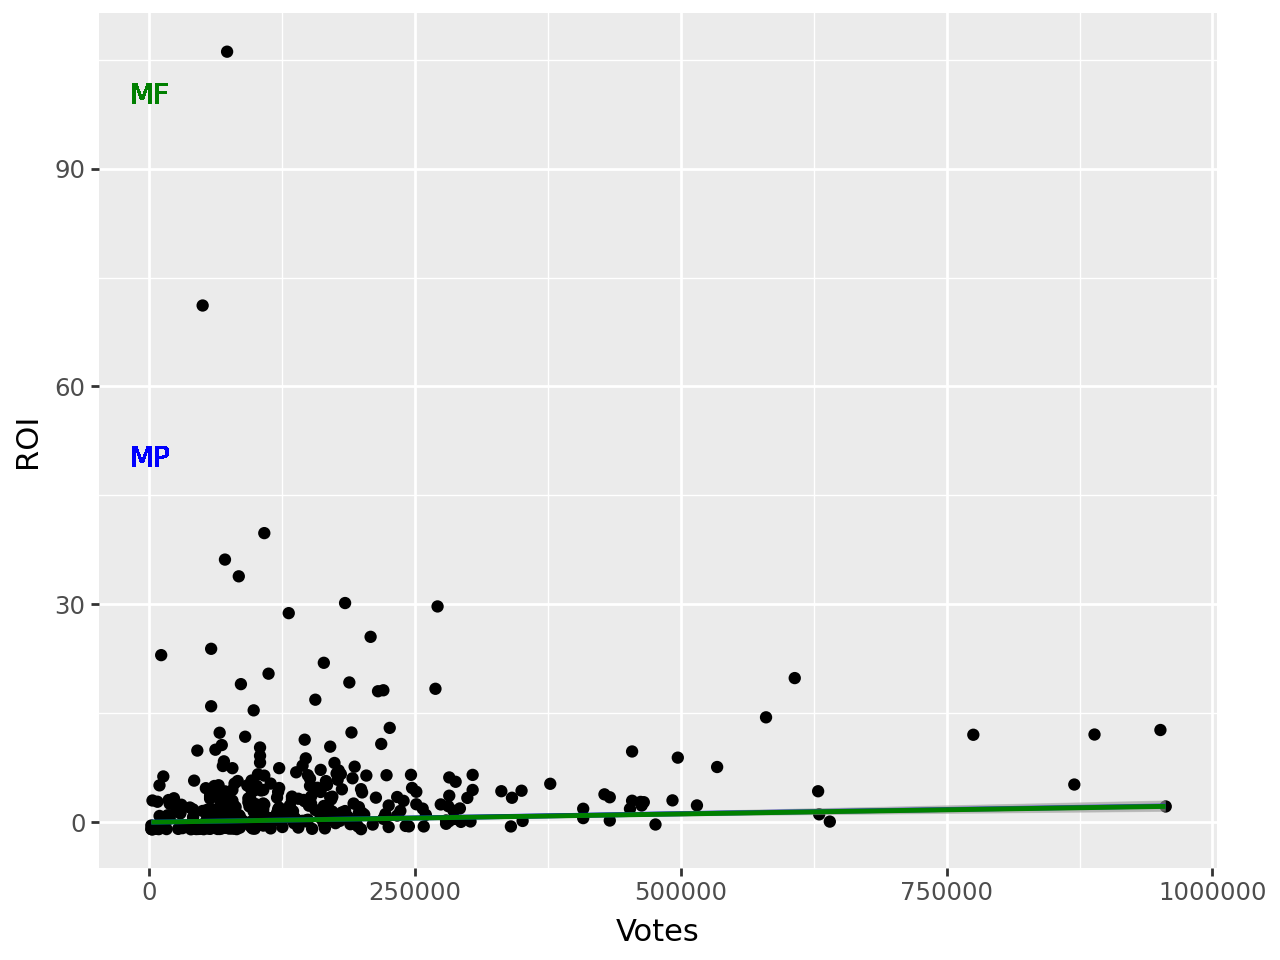

In [9]:
#Create a plot comparing actual ROI vs. predicted values from both models

import plotnine as p
p.ggplot(df) +\
  p.geom_point(p.aes(x='Votes', y='ROI')) +\
  p.geom_smooth(p.aes(x='Votes', y='y_multi_plot'), method='lm', color="blue") +\
  p.geom_smooth(p.aes(x='Votes', y='y_multi'), method='lm', color="green") +\
  p.geom_text(
      p.aes(x=100, y=100, label='"MF"'),
      color='green',
      size=10,
      inherit_aes=False) +\
  p.geom_text(
      p.aes(x=235, y=50, label='"MP"'),
      color='blue',
      size=10,
      inherit_aes=False)


In [ ]:
#PART 3: LLM

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Log in to Hugging Face with your API token
login(token="Your token")

# Choose a small but capable model (you can change it later)
model_name = "Qwen/Qwen2-1.5B-Instruct"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Use pipeline for simplicity
chatbot = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Define your prompt
prompt = """
You are a data-driven strategic advisor for film production companies.

Based on a regression analysis of 372 movies, we found that:
- Higher opening weekend revenue has the strongest positive impact on ROI.
- Higher similarity to top ROI moive has minor positive impact on ROI
- Higher IMDb ratings and more user votes also insignificantly improve ROI.
- Higher production budgets negatively impact ROI.
- The movie that has the highest ROI is Terrifier 2, and movies that have similar plot to it slightly have higher ROI compared to others.

What concrete, realistic, and actionable recommendations would you give to a mid-sized production studio that wants to:
1. Maximize ROI
2. Reduce unnecessary budget spending
3. Boost initial audience engagement

Respond in clear bullet points.
"""

# Generate response
output = chatbot(prompt, max_new_tokens=300, do_sample=True, temperature=0.7)[0]['generated_text']

print(output)


Device set to use cpu



You are a data-driven strategic advisor for film production companies.

Based on a regression analysis of 372 movies, we found that:
- Higher opening weekend revenue has the strongest positive impact on ROI.
- Higher similarity to top ROI moive has minor positive impact on ROI
- Higher IMDb ratings and more user votes also insignificantly improve ROI.
- Higher production budgets negatively impact ROI.
- The movie that has the highest ROI is Terrifier 2, and movies that have similar plot to it slightly have higher ROI compared to others.

What concrete, realistic, and actionable recommendations would you give to a mid-sized production studio that wants to:
1. Maximize ROI
2. Reduce unnecessary budget spending
3. Boost initial audience engagement

Respond in clear bullet points.
* Focus on producing movies with high opening weekend revenue, as this has the strongest positive impact on ROI.
	+ Prioritize projects with a strong track record of success.
* Invest in movies that are highly r